In [2]:
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from torchvision.ops import focal_loss
import torchvision.transforms.functional as transF
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from torch.utils.data import random_split
import random
from sklearn import preprocessing
from tqdm import tqdm
import cv2
import pandas as pd
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'torch'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


: 

: 

In [ ]:
class CFG:
    '''
    CFG
    Define hyperparameters used for preprocessing data and training model
    ----------
    Attributes
    ----------
        num_epochs: int
            Number of epochs need for training.
        batch_size: int
            Number of samples used for training in 1 iteration.
        num_workers: int
            Number of processor used in multiprocessing training.
        weight_decay: float (0 < weight_decay < 1)
            Percentage of neuron dropped out.
        mean: ndarray
            Mean values of the whole dataset
        std: ndarray
            Standard deviation values of the whole dataset.
        height: int
            Height of input image used for the input layer of model.
        width: int
            Width of input image used for the input layer of model.
        learning_rate: float
            Step size at each iteration defines how much to change the model.
        num_classes: int
            Number of output classes.
        target_names: list(str)
            Names of output classes.
    '''
    num_epochs = 20
    batch_size = 32
    num_workers = 2
    weight_decay = 1e-5
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    height = 224
    width = 224
    learning_rate = 0.001
    num_classes = 4
    le = preprocessing.LabelEncoder()
    path = './archive/data'
    stoi = {'cloudy' : 0, 'desert' : 1, 'green_area' : 2, 'water' : 3}
    itos = {0 :'cloudy', 1 : 'desert', 2 : 'green_area', 3 : 'water'}
    target_names = ['cloudy', 'desert', 'green_area', 'water']

: 

: 

In [ ]:
class ProcessData:
    def __init__(self, path = CFG.path):
        self.path = path

    def random_split_dataset(self):
        '''
        random_split_dataset(path = CFG.path)
        Split the dataset into 3 subsets included: train, validation and test.
        ----------
        Parameters
        ----------
        path : str, default=CFG.path
            `path` define the path to dataset
        ----------
        Returns
        ----------
        tuple(list(str))
            Tuple including 3 lists: train, validation, test. Each list contains paths to samples in dataset.
            The default ratio for 3 subset: train=0.6, validation=0.2, test=0.2
        '''
        random.seed(42)
        folders = os.listdir(self.path)
        CFG.num_classes = len(folders)
        data = []
        CFG.le.fit(folders)
        CFG.le_name_mapping = dict(zip(CFG.le.classes_, CFG.le.transform(CFG.le.classes_)))
        for folder in folders:
            for image_filename in os.listdir(os.path.join(self.path, folder)):
                data.append((image_filename, folder))
        print('num_classes', CFG.num_classes, 'length dataset', len(data))
        CFG.train_size = int(0.8*len(data))
        CFG.valid_size = int(0.1*len(data))
        CFG.test_size = len(data) - CFG.train_size - CFG.valid_size
        random.shuffle(data)
        return data[ : CFG.train_size], data[CFG.train_size : CFG.train_size + CFG.valid_size], data[CFG.train_size + CFG.valid_size : ]

    def get_transforms(self, transforms_type: str):
        '''
        get_transforms(transforms_type)
        ----------
        Parameters
        ----------
        transforms_type: str
            Refers to which dataset transformation applied on ('train', 'test', 'train')
        ----------
        Returns
        ----------
            If mode is 'train': return a transform.Compose object including steps:
                Resize, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize
            Else: return a transform.Compose object including steps:
                Resize, ToTensor, Normalize
        '''
        if transforms_type == 'train':
            return transforms.Compose([
                    transforms.Resize((CFG.width, CFG.height)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=CFG.mean,std=CFG.std)
                ])
        else:
            return transforms.Compose([
                transforms.Resize((CFG.width, CFG.height)),
                transforms.ToTensor(),
                transforms.Normalize(mean=CFG.mean,std=CFG.std)
            ])

: 

: 

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transforms_type = 'train'):
        self.data = data
        self.transforms = ProcessData().get_transforms(transforms_type)

    def __getitem__(self, idx):
        '''
        __getitem__(self, idx)
        Get item by index
        ----------
        Parameters
        ----------
        idx: int
            Index of the sample in dataset.
        ----------
        Returns
        ----------
        A tuple of (image: tensor, label: numeric)
        '''
        image_filename, class_name = self.data[idx]
        img_path = os.path.join(CFG.path, class_name, image_filename)
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img)
        return img, torch.tensor(CFG.le_name_mapping[class_name])

    def __len__(self):
        return len(self.data)

: 

: 

In [ ]:
class DatasetLoader:
    def __init__(self):
        self.process_data = ProcessData()

    def get_loaders(self):
        '''
        get_loaders:
            Split the dataset into 3 set: train, val and test. Each set will be converted into a CustomDataset object and transformed.
            Divided each dataset into batches for data loading.
        ----------
        Returns
        ----------
        A tuple of (train_loader, val_loader, test_loader)
        '''
        train_data, val_data, test_data = self.process_data.random_split_dataset()
        print(len(train_data), len(val_data), len(test_data))
        train_dataset = CustomDataset(train_data, transforms_type = 'train')
        val_dataset = CustomDataset(val_data, transforms_type = 'valid')
        test_dataset = CustomDataset(test_data, transforms_type = 'test')
        train_loader = DataLoader(dataset = train_dataset, batch_size = CFG.batch_size, shuffle = True)
        val_loader = DataLoader(dataset = val_dataset, batch_size = CFG.batch_size, shuffle = False)
        test_loader = DataLoader(dataset = test_dataset, batch_size = CFG.batch_size, shuffle = False)
        return train_loader, val_loader, test_loader

: 

: 

In [ ]:
train_loader, val_loader, test_loader = DatasetLoader().get_loaders()

num_classes 4 length dataset 5631
4504 563 564


: 

: 

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=CFG.weight_decay)

        self.conv1 = nn.Conv2d(3, 6, 4)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.conv3 = nn.Conv2d(12, 14, 4)
        self.conv4 = nn.Conv2d(14, 16, 4)
        self.conv5 = nn.Conv2d(16, 20, 4)

        self.fc1 = nn.Linear(20*4*4, 250)
        self.fc2 = nn.Linear(250, 200)
        self.fc3 = nn.Linear(200, 50)
        self.fc4 = nn.Linear(50, 20)
        self.fc5 = nn.Linear(20, CFG.num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.reshape(-1, 20*4*4)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)

        return x

: 

: 

In [ ]:
class Trainer:
    def __init__(self, model):
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)

    def train(self, train_loader):
        self.model.train()
        train_acc, correct_train, train_loss, target_count = 0, 0, 0, 0

        for images, labels in tqdm(train_loader):
            images = images.to(device).float()
            labels = labels.to(device).long()

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            train_loss += loss.item()

            # Backward and optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # accuracy
            _, predicted = torch.max(outputs, 1)
            target_count += labels.shape[0]
            correct_train += (labels == predicted).sum().item()
            train_acc = (100 * correct_train) / target_count
        return train_acc, train_loss / target_count

    def validate(self, val_loader):
        self.model.eval()
        val_acc, correct_val, val_loss, target_count = 0, 0, 0, 0
        for images, labels in tqdm(val_loader):
            images = images.to(device).float()
            labels = labels.to(device).long()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            target_count += labels.shape[0]
            correct_val += (labels == predicted).sum().item()
            val_acc = (100 * correct_val) / target_count
        return val_acc, val_loss / target_count

    def fit(self, model, the_last_loss = 100, patience = 10, trigger_times = 0, isStopped = False):
        self.train_acc_history = []
        self.train_loss_history = []
        self.val_acc_history = []
        self.val_loss_history = []

        for epoch in range(0, CFG.num_epochs):

            train_acc, train_loss = self.train(train_loader)
            self.train_acc_history.append(train_acc)
            self.train_loss_history.append(train_loss)

            val_acc,val_loss = self.validate(val_loader)
            self.val_acc_history.append(val_acc)
            self.val_loss_history.append(val_loss)

            print("Epoch {}: train_acc {:.6f} \t train_loss {:.6f} \t val_acc {:.6f} \t val_loss {:.6f}".format(epoch+1, train_acc, train_loss, val_acc, val_loss))
            print("Learning rate: {}".format(self.optimizer.param_groups[0]["lr"]))
            the_current_loss = val_loss

            if the_current_loss > the_last_loss:
                trigger_times += 1
                print('trigger times: ', trigger_times)
                if trigger_times >= patience:
                    print('Early stopping! at epoch {0}'.format(epoch+1))
                    isStopped = True
                    break
            else:
                print('trigger times: 0')
                trigger_times = 0
                the_last_loss = the_current_loss
                if not isStopped:
                    torch.save(self.model.state_dict(), 'model.pth')
                    torch_script_model = torch.jit.script(self.model)
                    torch_script_model.save('model.pt')
                    print('Validation loss {:.6f}.  Saving model ...'.format(the_current_loss))

    def plot_his_acc(self):
        plt.figure(figsize=(25,5))
        plt.plot(self.train_acc_history,'-o')
        plt.plot(self.val_acc_history,'-o')
        plt.xlabel('epoch')
        plt.ylabel('Accuracy')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
        plt.legend(['Train_Acc','Val_Acc'])
        plt.title('Train Acc and Val Acc')
        plt.show()

    def plot_his_loss(self):
        plt.figure(figsize=(25,5))
        plt.plot(self.train_loss_history,'-o')
        plt.plot(self.val_loss_history,'-o')
        plt.xlabel('epoch')
        plt.ylabel('losses')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
        plt.legend(['Train_Loss','Val_Loss'])
        plt.title('Train Loss and Val Loss')
        plt.show()

: 

: 

In [ ]:
model = BaseModel()
model = model.to(device)

: 

: 

In [ ]:
trainer = Trainer(model)
trainer.fit(model)

100%|██████████| 18/18 [00:01<00:00, 14.54it/s]


Epoch 1: train_acc 45.759325 	 train_loss 0.027599 	 val_acc 48.490231 	 val_loss 0.023862
Learning rate: 0.001
trigger times: 0
Validation loss 0.023862.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 14.19it/s]


Epoch 2: train_acc 50.244227 	 train_loss 0.023549 	 val_acc 55.239787 	 val_loss 0.022543
Learning rate: 0.001
trigger times: 0
Validation loss 0.022543.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 12.54it/s]


Epoch 3: train_acc 55.039964 	 train_loss 0.022221 	 val_acc 59.325044 	 val_loss 0.022745
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:01<00:00, 14.40it/s]


Epoch 4: train_acc 58.192718 	 train_loss 0.020955 	 val_acc 64.298401 	 val_loss 0.021961
Learning rate: 0.001
trigger times: 0
Validation loss 0.021961.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 13.81it/s]


Epoch 5: train_acc 65.497336 	 train_loss 0.019528 	 val_acc 69.094139 	 val_loss 0.017816
Learning rate: 0.001
trigger times: 0
Validation loss 0.017816.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 13.98it/s]


Epoch 6: train_acc 66.274423 	 train_loss 0.018347 	 val_acc 67.140320 	 val_loss 0.016749
Learning rate: 0.001
trigger times: 0
Validation loss 0.016749.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 14.27it/s]


Epoch 7: train_acc 68.539076 	 train_loss 0.017420 	 val_acc 68.738899 	 val_loss 0.015720
Learning rate: 0.001
trigger times: 0
Validation loss 0.015720.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 12.38it/s]


Epoch 8: train_acc 72.024867 	 train_loss 0.015876 	 val_acc 81.172291 	 val_loss 0.014466
Learning rate: 0.001
trigger times: 0
Validation loss 0.014466.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 13.77it/s]


Epoch 9: train_acc 75.865897 	 train_loss 0.015562 	 val_acc 70.692718 	 val_loss 0.015637
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:01<00:00, 14.71it/s]


Epoch 10: train_acc 78.574600 	 train_loss 0.015185 	 val_acc 86.323268 	 val_loss 0.013794
Learning rate: 0.001
trigger times: 0
Validation loss 0.013794.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 14.41it/s]


Epoch 11: train_acc 78.996448 	 train_loss 0.014544 	 val_acc 87.744227 	 val_loss 0.012835
Learning rate: 0.001
trigger times: 0
Validation loss 0.012835.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 11.82it/s]


Epoch 12: train_acc 81.261101 	 train_loss 0.014081 	 val_acc 86.678508 	 val_loss 0.012005
Learning rate: 0.001
trigger times: 0
Validation loss 0.012005.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 13.28it/s]


Epoch 13: train_acc 80.017762 	 train_loss 0.013989 	 val_acc 84.724689 	 val_loss 0.012902
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:01<00:00, 14.02it/s]


Epoch 14: train_acc 81.727353 	 train_loss 0.013134 	 val_acc 85.435169 	 val_loss 0.012087
Learning rate: 0.001
trigger times:  2


100%|██████████| 18/18 [00:01<00:00, 13.70it/s]


Epoch 15: train_acc 81.039076 	 train_loss 0.013663 	 val_acc 85.612789 	 val_loss 0.013800
Learning rate: 0.001
trigger times:  3


100%|██████████| 18/18 [00:01<00:00, 14.15it/s]


Epoch 16: train_acc 81.660746 	 train_loss 0.013568 	 val_acc 85.612789 	 val_loss 0.012760
Learning rate: 0.001
trigger times:  4


100%|██████████| 18/18 [00:01<00:00, 12.34it/s]


Epoch 17: train_acc 82.926288 	 train_loss 0.012841 	 val_acc 88.277087 	 val_loss 0.011391
Learning rate: 0.001
trigger times: 0
Validation loss 0.011391.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 13.95it/s]


Epoch 18: train_acc 82.415631 	 train_loss 0.012990 	 val_acc 73.889876 	 val_loss 0.017813
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:01<00:00, 14.39it/s]


Epoch 19: train_acc 83.170515 	 train_loss 0.012217 	 val_acc 89.875666 	 val_loss 0.009948
Learning rate: 0.001
trigger times: 0
Validation loss 0.009948.  Saving model ...


100%|██████████| 18/18 [00:01<00:00, 13.49it/s]

Epoch 20: train_acc 84.125222 	 train_loss 0.012015 	 val_acc 81.882771 	 val_loss 0.012177
Learning rate: 0.001
trigger times:  1


: 

: 

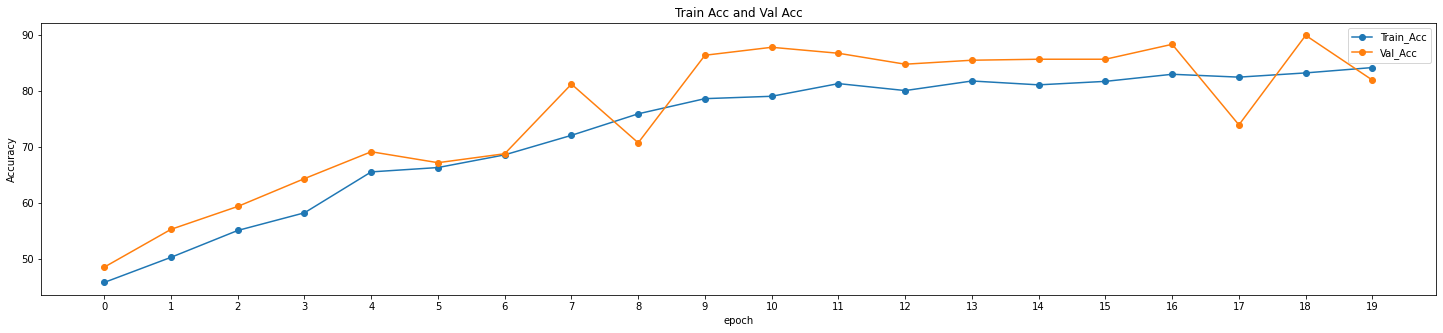

: 

: 

In [ ]:
trainer.plot_his_acc()

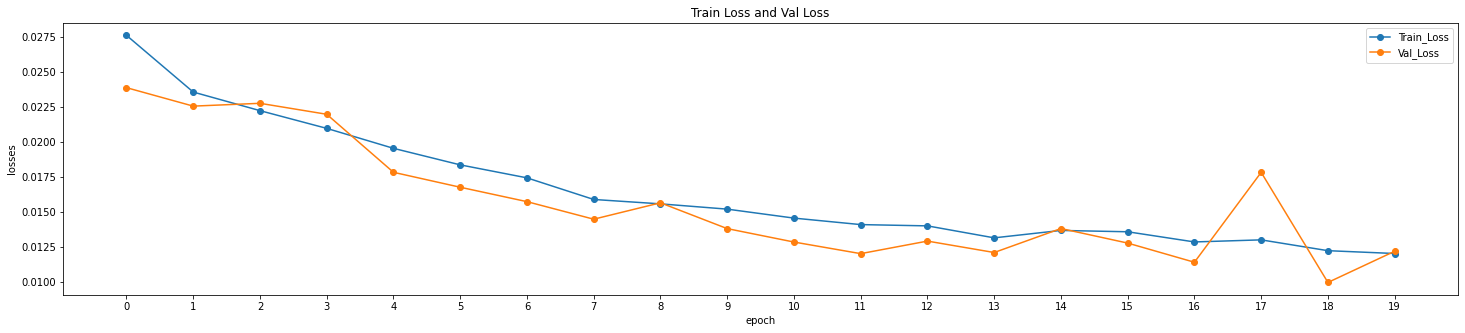

: 

: 

In [ ]:
trainer.plot_his_loss()

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    pred_list = []
    label_list = []
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        running_loss=0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            pred_list.extend(predictions.cpu().numpy())
            label_list.extend(labels.cpu().numpy())
            n_samples += labels.shape[0]
            n_correct += (predictions == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
    return acc, pred_list, label_list

: 

: 

In [ ]:
acc, pred_list, label_list = evaluate_model(model, test_loader)
print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 81.38297872340425 %


: 

: 